# DES	simulation	assignment

Michael MacFarlane Glasow  
Rinske Oskamp  
Ruben Lanjouw  


We made all the code right here. Ignore the plots part its just 1 mess.

### 0 Imports

In [ ]:
import simpy
import numpy as np
import random
import matplotlib.pyplot as plt
import math
import statistics

### 1 Proof DES_queue

In [63]:
def DES_queue(size, arrival_rate, service_rate, n):
    """
    size = number of customers
    arrival_rate = rate of arrival of customers, lambda
    service_rate = rate of service of customers, mu
    n = number of servers
    """

    env = simpy.Environment()
    servers = simpy.Resource(env, capacity = n)

    inter_arrival_times = []
    service_times = []
    waiting_times = []


    def customer_processing(env, servers, arrival_rate, service_rate):
        ''' Process the customer'''
        arrival_time = env.now # time now

        with servers.request() as request:
            yield request  # wait untill the server is available
            wait_time = env.now - arrival_time
            waiting_times.append(wait_time)  # save the wait time
            ds = random.expovariate(service_rate)
            service_times.append(ds)
            yield env.timeout(ds)

    def customer_generator(env, size , servers, arrival_rate, service_rate):
        ''' Generates a costumer after a delay of the arrival time and processes the customer  '''
        # make numpy expovariate list
        for i in range(size):
            dt = random.expovariate(arrival_rate)
            inter_arrival_times.append(dt)
            yield env.timeout(dt) # wait for the next customer
            costomer = customer_processing(env,servers,arrival_rate,service_rate)
            env.process(costomer)

    env.process(customer_generator(env, size, servers,arrival_rate,service_rate))

    env.run()
    
    mean_interarrival = statistics.mean(inter_arrival_times)
    mean_waiting = statistics.mean(waiting_times)
    mean_service = statistics.mean(service_times)

    return [mean_interarrival, mean_waiting, mean_service, waiting_times]


# test run
size = 1000
arrival_rate = 1
service_rate = 1
n = 1
result = DES_queue(size, arrival_rate, service_rate, n)
print(result)


[0.984917911643026, 27.917746791069824, 1.025254494114264, [0.0, 0.0, 1.5187855237072636, 1.595308625117426, 5.674953260696514, 5.345219669842982, 4.604543810746267, 4.44175789705568, 6.423147110758815, 6.975711543799508, 7.037267517802054, 9.923919906416828, 9.302936805541405, 6.049077670441809, 7.013942633879106, 7.420880946327811, 10.423680638768017, 10.900153701282967, 10.84576417789454, 11.959294323615605, 10.567847268732923, 10.504748650022695, 9.909495947619334, 9.451928385764113, 7.932418349499052, 6.462373572073407, 5.8479370073570465, 5.195277731921269, 4.739745799654376, 6.722951652921054, 7.345375605071656, 7.098619506867639, 8.418369962718025, 9.008785176306493, 8.973794686725057, 8.83570766030747, 9.212362366907485, 8.262094771380639, 7.972127332847279, 6.71590258677341, 6.024067126285345, 6.68555491119362, 6.453953281682942, 6.41092864381266, 8.218304569893782, 8.362791073148458, 8.042110954389756, 7.161930043463833, 7.511434198312109, 8.265163989701655, 10.8748692667472

### 2 Proof significance 

In [ ]:

def calculate_expected_waiting_time(n, p, u):
    if p >= 1:
        return "P DOES NOT WORK! DO NORMAL PLS :)"
    
    hfirst_term = ((n * p ) ** n) / math.factorial(n)
    
    hsecond_term = (1 - p) * sum(((n * p) ** i) / math.factorial(i) for i in range(n))
    hsecond_term += ((n * p) ** n) / math.factorial(n)
    hsecond_term = 1 / hsecond_term
    h = hfirst_term * hsecond_term
    second_term1 = 1 / (1 - p)
    second_term2 = 1 / (n * u)
    expected_waiting_time = h * second_term1 * second_term2

    return expected_waiting_time


def calculate_DES(number_of_rounds, arrival_rate, service_rate, number_of_servers, number_of_customers):
    results_waiting = []
    for _ in range(number_of_rounds):
        result = DES_queue(number_of_customers, arrival_rate, service_rate, number_of_servers, rate_prob=True, arrival_prob=True)
        results_waiting.append(result[1])
    return np.mean(results_waiting), np.std(results_waiting), results_waiting


### 3 Shortest Job First

In [ ]:
def DES_queue_SJF(size, arrival_rate, service_rate, n):
    """
    size = number of customers
    arrival_rate = rate of arrival of customers, lambda
    service_rate = rate of service of customers, mu
    n = number of servers
    """
    env = simpy.Environment()
    servers = simpy.Resource(env, capacity = n)

    inter_arrival_times = []
    service_times = []
    waiting_times = []


    def customer_processing(env, queue, size):
        ''' Process the customers with while loop checking for shortest job first'''
        processed = 0
        while processed < size:
            if len(queue) == 0:
                yield env.timeout(0.1)
                continue
            shortest_job = min(queue, key=lambda x: x["service"])
            ds = shortest_job["service"]
            queue.remove(shortest_job)
            with servers.request() as request:
                yield request
                wait_time = env.now - shortest_job["arrival"]
                waiting_times.append(wait_time)
                service_times.append(ds)
                yield env.timeout(ds)
            processed += 1


    def customer_generator(env, size, arrival_rate, service_rate, queue):
        ''' Generates a costumer after a delay of the arrival time and processes the customer  '''
        # make 

        for i in range(size):
            dt = random.expovariate(arrival_rate)
            inter_arrival_times.append(dt)
            yield env.timeout(dt) # wait for the next customer
            ds = random.expovariate(service_rate)
            queue.append({"arrival" : env.now, "service" : ds})

    queue = []
    env.process(customer_generator(env, size,arrival_rate,service_rate, queue))
    env.process(customer_processing(env, queue,size))
    env.run()
    
    mean_interarrival = statistics.mean(inter_arrival_times)
    mean_waiting = statistics.mean(waiting_times)
    mean_service = statistics.mean(service_times)
    return [mean_interarrival, mean_waiting, mean_service, waiting_times]

u = 1
p = 0.7
n = 1
lambd = n * p * u
DES_queue_SJF(100,lambd, u, n)[1]

In [ ]:
def DES_deter(size, arrival_rate, service_rate, n, method="deterministic"):
    """
    size = number of customers
    arrival_rate = rate of arrival of customers, lambda
    service_rate = rate of service of customers, mu
    n = number of servers
    """

    env = simpy.Environment()
    servers = simpy.Resource(env, capacity = n)

    inter_arrival_times = []
    service_times = []
    waiting_times = []


    def customer_processing(env, servers, service_rate, method="deterministic"):
        ''' Process the customer'''
        arrival_time = env.now # time now

        with servers.request() as request:
            yield request  # wait untill the server is available
            wait_time = env.now - arrival_time
            waiting_times.append(wait_time)  # save the wait time
            if method=="deterministic": # choose right method
                ds = service_rate
            if method=="longtail":
                ds = random.expovariate(1) if random.random() < 0.75 else random.expovariate(5)
            else:
                ds = random.expovariate(service_rate)
            service_times.append(ds)
            yield env.timeout(ds)

    def customer_generator(env, size , servers, arrival_rate, service_rate, method):
        ''' Generates a costumer after a delay of the arrival time and processes the customer  '''
        # make numpy expovariate list
        for i in range(size):
            dt = random.expovariate(arrival_rate)
            inter_arrival_times.append(dt)
            yield env.timeout(dt) # wait for the next customer
            costomer = customer_processing(env,servers,service_rate, method)
            env.process(costomer)

    env.process(customer_generator(env, size, servers,arrival_rate,service_rate, method))

    env.run()
    
    mean_interarrival = statistics.mean(inter_arrival_times)
    mean_waiting = statistics.mean(waiting_times)
    mean_service = statistics.mean(service_times)

    return [mean_interarrival, mean_waiting, mean_service, waiting_times]


### Plots

In [ ]:
nl = [1,2,4]
u = 1
p = np.linspace(0.1, 0.99, 30)
for n in nl:
    mean = []
    lambd = u * p * n
    for p_i in p:
        lambd = u * p_i * n
        results = []
        # results2 = []
        for _ in range(5):
            result = DES_queue(10000, lambd, u, n)
            results.append(np.std(result[3]))
            # results2.append(result[1])
        # avr.append(np.mean(results2))
        mean.append(np.mean(results))
    plt.plot(p, mean, label=f"n={n}")

plt.legend()
plt.xlabel("\u03C1")
plt.ylabel("Standard deviation")
plt.show()

# make the avr relative to mean

In [75]:
# plot the mean waiting time for different number of servers with a confidence interval
servers = [1,2,4]
number_of_customers = 1000
rho = 0.7
mu = 10
number_of_rounds = 100
means = []
total = []
stds = []

for n in servers:
    results = []
    lambd = (n * mu * rho)
    for i in range(number_of_rounds):
        result = DES_queue(number_of_customers, lambd, mu, n)
        results.append(result[1])
        if i % 100 == 0:
            print("Finished round ", i)
    mean = np.mean(results)
    std = np.std(results)
    means.append(mean)
    stds.append(std)
    total.append(results)
    print("Finished for n = ", n)

print(means)


Finished round  0
Finished for n =  1
Finished round  0
Finished for n =  2
Finished round  0
Finished for n =  4
[0.22475802597555736, 0.09235428363202973, 0.035003508212012945]


[0.22475803 0.09235428 0.03500351]


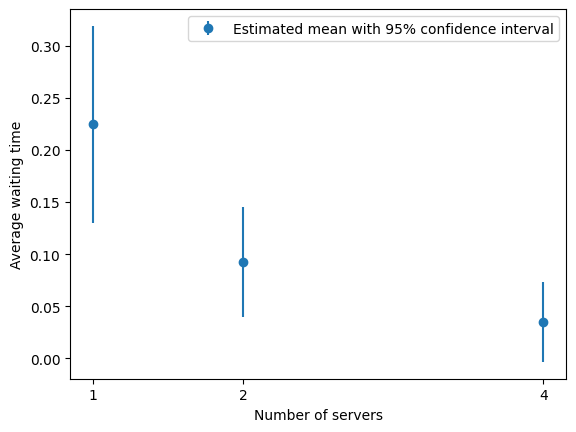

1 & 0.225 & 0.130 & 0.319 & 0.233 \\
2 & 0.092 & 0.039 & 0.145 & 0.096 \\
4 & 0.035 & -0.003 & 0.073 & 0.036 \\
n=1 & n=2 & n=4 \\
0.000 & 0.000 & 0.000 \\


In [ ]:
np.save("means_p07_mu10_10000cust_100times.npy", means)
np.save("stds_p07_mu10_10000cust_100times.npy", stds)



means1 = np.load("means_p07_mu10_10000cust_100times.npy")
stds1 = np.load("stds_p07_mu10_10000cust_100times.npy")
servers = [1,2,4]
number_of_customers = 10000
rho = 0.7
mu = 10
number_of_rounds = 1000
print(means1)
convi = 1.96
plt.errorbar(servers, means1, yerr=1.96*stds1, fmt='o', label="Estimated mean with 95% confidence interval")
plt.xlabel("Number of servers")
plt.ylabel("Average waiting time")
plt.legend()
plt.xticks(servers)
plt.show()

convi = 1.96
for i in range(len(servers)):
    print(f"{servers[i]} & {means1[i]:.3f} & {means1[i] - convi*stds1[i]:.3f} & {means1[i] + convi*stds1[i]:.3f} & {calculate_expected_waiting_time(servers[i], 0.7, 10):.3f} \\\\")


from scipy.stats import ttest_ind
a= ttest_ind(total[0], total[1])
b = ttest_ind(total[0], total[2])
c = ttest_ind(total[1], total[2])

print("n=1 & n=2 & n=4 \\\\")
print(f"{a.pvalue:.3f} & {b.pvalue:.3f} & {c.pvalue:.3f} \\\\")



1
2
4
1
2
4
1
2
4


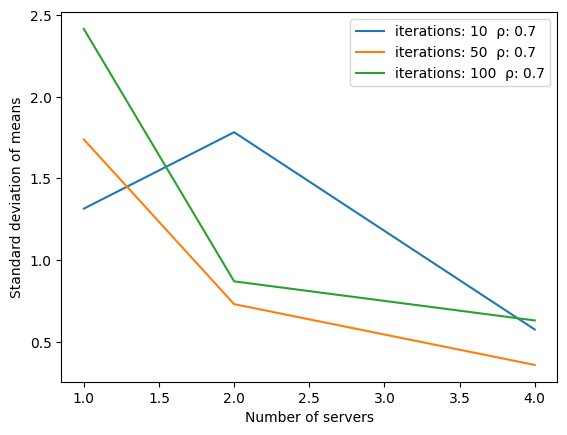

In [55]:
# proove that confidence interval is decreasing with more runs
number_of_customers = 10000
iterations = [10,50, 100]
means = []
stds = []
mu = 1
n = [1,2,4]
rho = 0.9
# make 4 lines over the different n with on y axis range of 95% confidence interval
for it in iterations:
    means = []
    stds = []
    for n_i in n:
        results = []
        lambd = (n_i * mu * rho)
        for i in range(it):
            result = DES_queue(number_of_customers, lambd, mu, n_i)
            results.append(result[1])
        mean = np.mean(results)
        std = np.std(results)
        means.append(mean)
        stds.append(std)
        print(n_i)
    plt.plot(n, stds, label=f"iterations: {it}  \u03C1: 0.7")
plt.legend()
plt.xlabel("Number of servers")
plt.ylabel("Standard deviation of means")
plt.show()


500
1000
2000
5000
10000


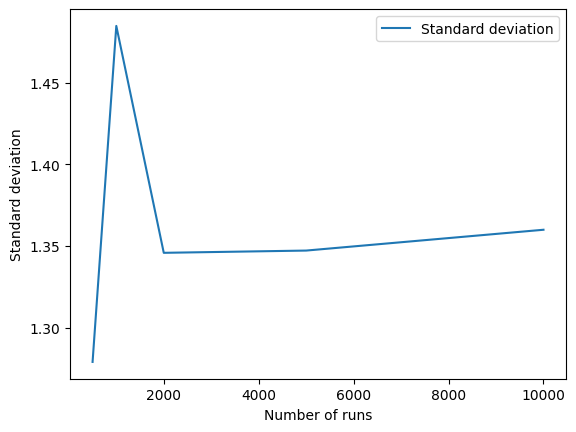

In [ ]:
number_of_runs =[500,1000,2000,5000,10000]
p = 0.7
m = 1
n = 1
number_of_customers = 1000

def calculate(n, p, m, number_of_customers, number_of_runs):
    results = []
    for _ in range(number_of_runs):
        result = DES_queue(number_of_customers, n*p*m, m, n)
        results.append(result[1])
    return results

means = []
stds = []
for run in number_of_runs:
    results = calculate(n, p, m, number_of_customers, run)
    means.append(np.mean(results))
    stds.append(np.std(results))
    print(run)

# plt.plot(number_of_runs, means, label="Mean waiting time")
plt.plot(number_of_runs, stds, label="Standard deviation")
plt.legend()
plt.xlabel("Number of runs")
plt.ylabel("Standard deviation")
plt.show()


# calculate the std over ther runs

In [ ]:
number_of_customers = 1000
rho = [0.1,0.3,0.5,0.7,0.9]
mu = 1
number_of_rounds = 100
meansSJF = []
meansFIFO = []
stdsSJF = []
stdsFIFO = []
n = 1
for rho_i in rho:
    resultsSJF = []
    resultsFIFO = []
    lambd = (n * mu * rho_i)
    for i in range(number_of_rounds):
        resultSJF = DES_queue_SJF(number_of_customers, lambd, mu, n)
        resultFIFO = DES_queue(number_of_customers, lambd, mu, n)
        resultsSJF.append(resultSJF[1])
        resultsFIFO.append(resultFIFO[1])
        if i % 100 == 0:
            print("Finished round ", i)
    meanSJF = np.mean(resultsSJF)
    meanFIFO = np.mean(resultsFIFO)
    stdSJF = np.std(resultsSJF)
    stdFIFO = np.std(resultsFIFO)
    meansSJF.append(meanSJF)
    meansFIFO.append(meanFIFO)
    print("Finished for rho = ", rho_i)

plt.plot(rho, meansSJF, label="Shortest job first")
plt.fill_between(rho, np.array(meansSJF) - 1.96*np.array(stdsSJF), np.array(meansSJF) + 1.96*np.array(stdsSJF), alpha=0.5)
plt.plot(rho, meansFIFO, label="First in first out")
plt.fill_between(rho, np.array(meansFIFO) - 1.96*np.array(stdsFIFO), np.array(meansFIFO) + 1.96*np.array(stdsFIFO), alpha=0.5)
plt.xlabel("\u03C1")    
plt.ylabel("Average waiting time")
plt.legend()
plt.show()


In [ ]:
# Comparison between deterministic and longtail and normal for n = 1
def make_n_plots(n=1):
    rho = np.linspace(0.1, 0.9, 10)
    mu = 1
    number_of_customers = 1000
    number_of_rounds = 100
    meansD = []
    meansL = []
    meansN = []
    for rho_i in rho:
        resultsD = []
        resultsL = []
        resultsN = []
        lambd = (n * mu * rho_i)
        for i in range(number_of_rounds):
            resultD = DES_deter(number_of_customers, lambd, mu, n, method="deterministic")
            resultL = DES_deter(number_of_customers, lambd, mu, n, method="longtail")
            resultN = DES_deter(number_of_customers, lambd, mu, n, method="normal")
            resultsD.append(resultD[1])
            resultsL.append(resultL[1])
            resultsN.append(resultN[1])
            # if i % 100 == 0:
            #     print("Finished round ", i)
        meanD = np.mean(resultsD)
        meanL = np.mean(resultsL)
        meanN = np.mean(resultsN)
        meansD.append(meanD)
        meansL.append(meanL)
        meansN.append(meanN)
        print("Finished for rho = ", rho_i)
    return meansD, meansL, meansN

meansD, meansL, meansN = make_n_plots(1)
meansD2, meansL2, meansN2 = make_n_plots(2)
meansD4, meansL4, meansN4 = make_n_plots(4)


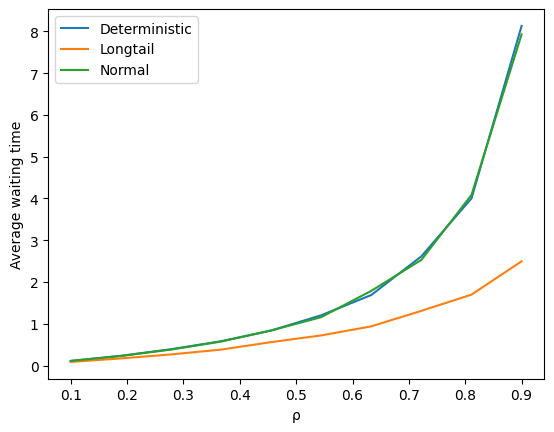

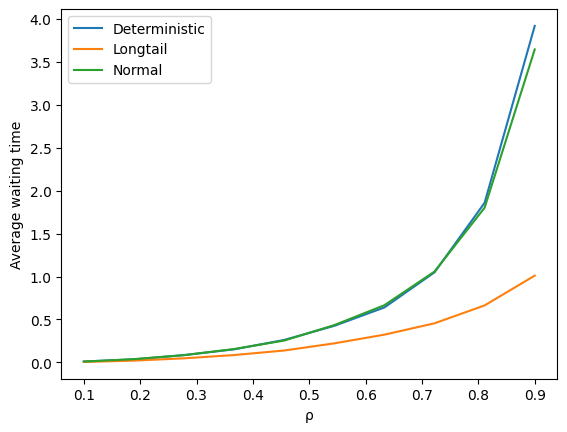

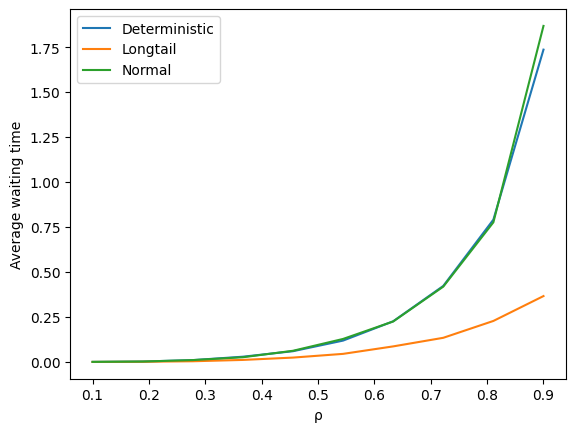

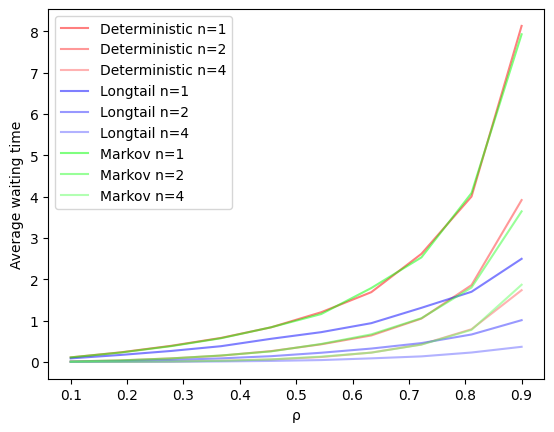

In [ ]:
def make_plot(meansD, meansL, meansN, rho):
    plt.plot(rho, meansD, label="Deterministic")
    plt.plot(rho, meansL, label="Longtail")
    plt.plot(rho, meansN, label="Normal")
    plt.xlabel("\u03C1")
    plt.ylabel("Average waiting time")
    plt.legend()
    plt.show()


def make1_plot(all_meansD, all_meansL, all_meansN, rho):
    # 3 red colors formula
    colors = ["#FF0000", "#FF3333", "#FF6666"]
    plt.plot(rho, all_meansD[0], label="Deterministic n=1",color=colors[0], alpha=0.5)
    plt.plot(rho, all_meansD[1], label="Deterministic n=2",color=colors[1], alpha=0.5)
    plt.plot(rho, all_meansD[2], label="Deterministic n=4",color=colors[2], alpha=0.5)
    # 3 blue colors formula
    colors = ["#0000FF", "#3333FF", "#6666FF"]
    plt.plot(rho, all_meansL[0], label="Longtail n=1", color=colors[0], alpha=0.5)
    plt.plot(rho, all_meansL[1], label="Longtail n=2", color=colors[1], alpha=0.5)
    plt.plot(rho, all_meansL[2], label="Longtail n=4", color=colors[2], alpha=0.5)
    # 3 green colors formula
    colors = ["#00FF00", "#33FF33", "#66FF66"]
    plt.plot(rho, all_meansN[0], label="Markov n=1", color=colors[0], alpha=0.5)
    plt.plot(rho, all_meansN[1], label="Markov n=2", color=colors[1], alpha=0.5)
    plt.plot(rho, all_meansN[2], label="Markov n=4", color=colors[2], alpha=0.5)
    plt.xlabel("\u03C1")
    plt.ylabel("Average waiting time")
    plt.legend()
    plt.show()

all_meansD = [meansD, meansD2, meansD4]
all_meansL = [meansL, meansL2, meansL4]
all_meansN = [meansN, meansN2, meansN4]


make_plot(meansD, meansL, meansN, rho)
make_plot(meansD2, meansL2, meansN2, rho)
make_plot(meansD4, meansL4, meansN4, rho)
make1_plot(all_meansD, all_meansL, all_meansN, rho)